#  Masking Pipeline

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)


In [1]:
#!env

In [2]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *

In [3]:
%matplotlib notebook

In [4]:
from pyCHX.chx_generic_functions import RemoveHot,create_multi_rotated_rectangle_mask

# Path for Saving Results

In [5]:
CYCLE= '2019_3'  #change clycle here

In [6]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2019_3/masks/


### Get the image series and metadata from the uid

In [7]:

uid = 'bb67c166' # (scan num: 11072) (Measurement: single image for mask 4m )





In [8]:
#get_last_uids( -2 )
#path

In [9]:
md = get_meta_data( uid )
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])

print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

filepath : /nsls2/xf11id1/data/2019/05/15/ced99e7f-7b4a-41e9-9662
got images_per_file
Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  11072--bb67c166-8599-4640-83ab-b65c4c22243c--/nsls2/xf11id1/data/2019/05/15/ced99e7f-7b4a-41e9-9662_4331_master.h5


In [10]:
#print(md['beam_center_y'], md['beam_center_x'])

In [11]:
imgs = load_data( uid, detector, reverse= False  )
#imgs = load_data( uid, detector, reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

/opt/conda_envs/analysis-2019-1.2-chx/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


The data are: EigerImages processed through proc_func. Original repr:
    <Frames>
    Length: 1 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint32


In [12]:
pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [13]:
img_choice_N = 1  #can change this number to select more frames for average
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgs, img_samp_index, plot_ = False, uid = uid)

## show image and the pixel mask

* show image

<IPython.core.display.Javascript object>


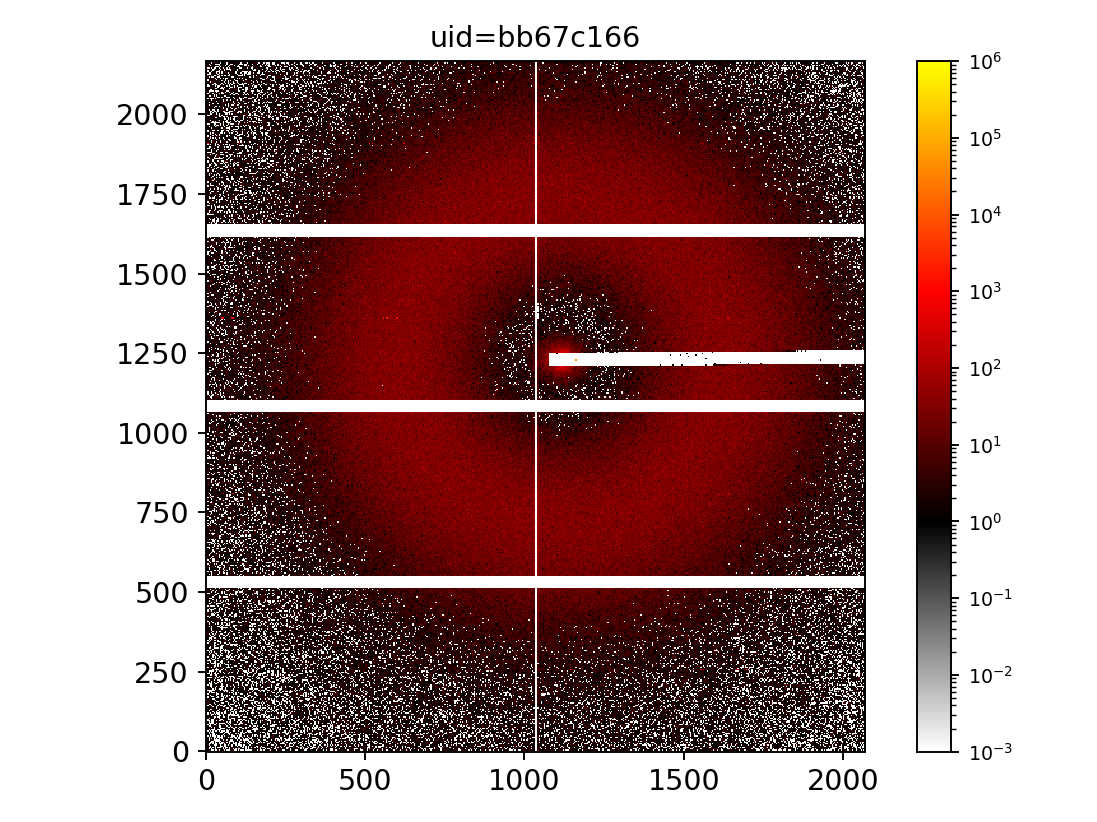

In [14]:
show_img(  avg_img*pixel_mask , vmin=.001, vmax=1e6, logs=True, 
         image_name ='uid=%s'%uid, aspect=1, cmap= cmap_albula  )


* pixel mask

### Update Pixel Mask due to bad pixel of Eiger Detector

In [15]:
pixel_mask = mask_badpixels( pixel_mask, md['detector'])

<IPython.core.display.Javascript object>


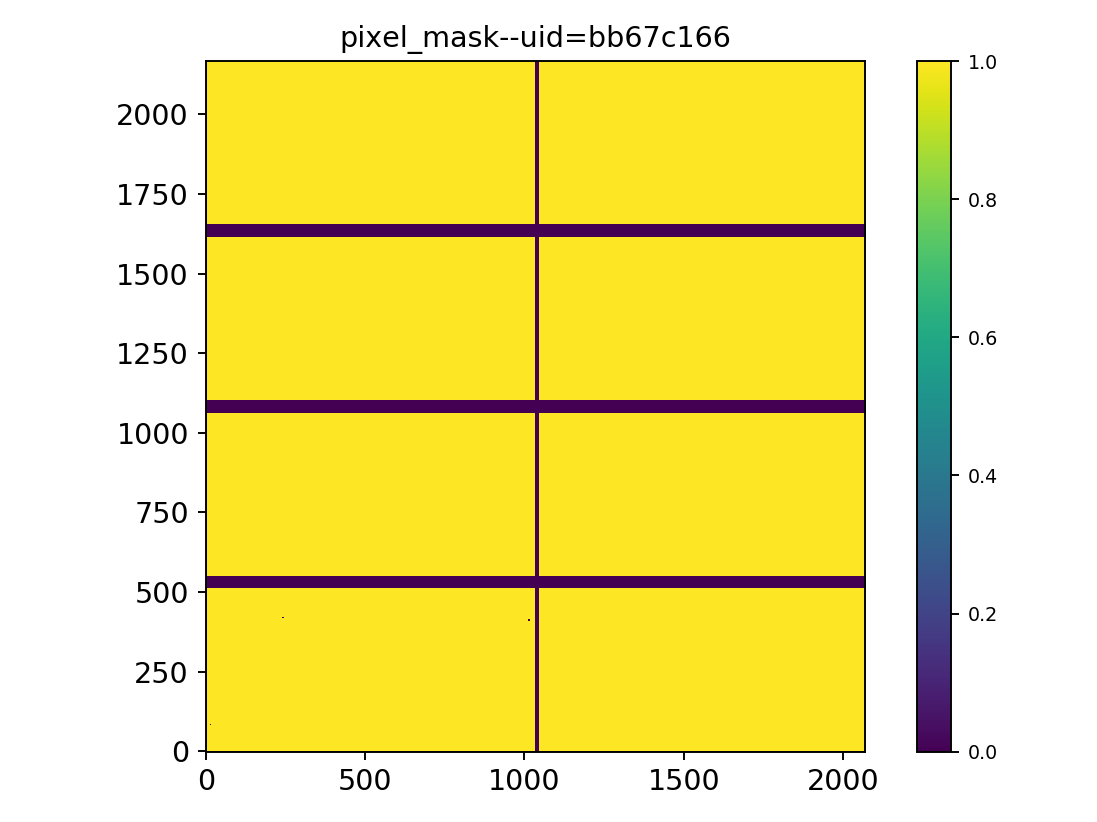

In [16]:
show_img( pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid ,aspect=1 )

## Remove hotspots in the image

In [17]:
#avg_img =  get_avg_img( imgs, sampling = 10, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


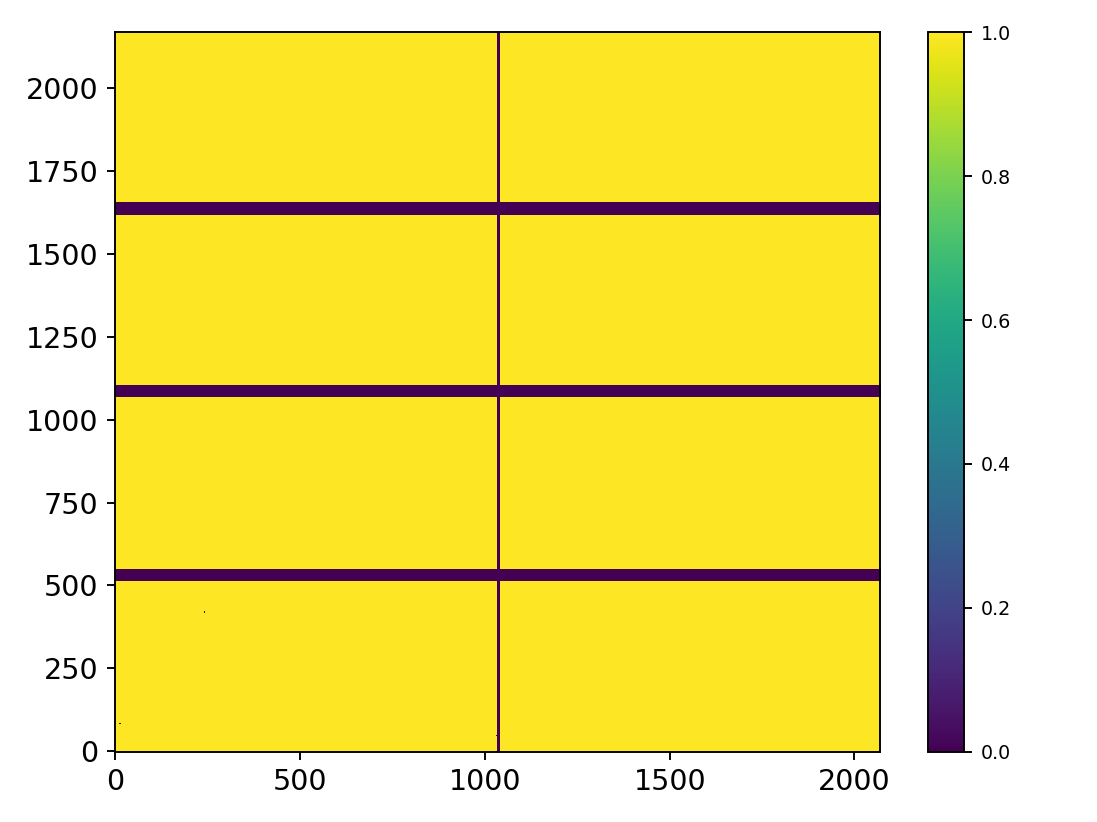

In [18]:
mask_rh  = RemoveHot( avg_img, 2**20-1, plot_=True)

<IPython.core.display.Javascript object>


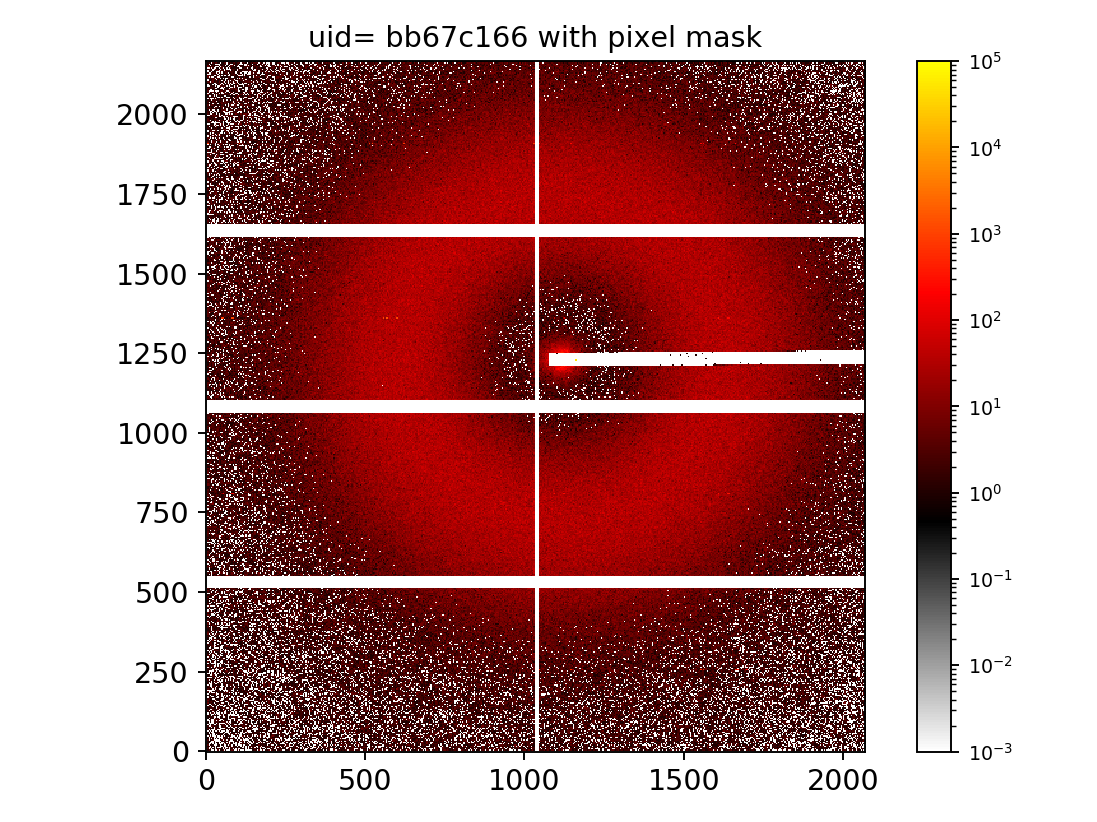

In [19]:
show_img(avg_img*pixel_mask,vmin=0.1e-2,vmax=1e5, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

# Create a polygon mask

* check beam center

In [20]:
md['beam_center_x'], md['beam_center_y']

(1115.0, 1229.0)

In [21]:
imgs[0].shape

(2167, 2070)

## Create a rotated region

In [22]:
rmask = create_multi_rotated_rectangle_mask( imgs[0], 
                                center= [ md['beam_center_x'], md['beam_center_y']   ], length=0, width=0, angles=[0] )

<IPython.core.display.Javascript object>


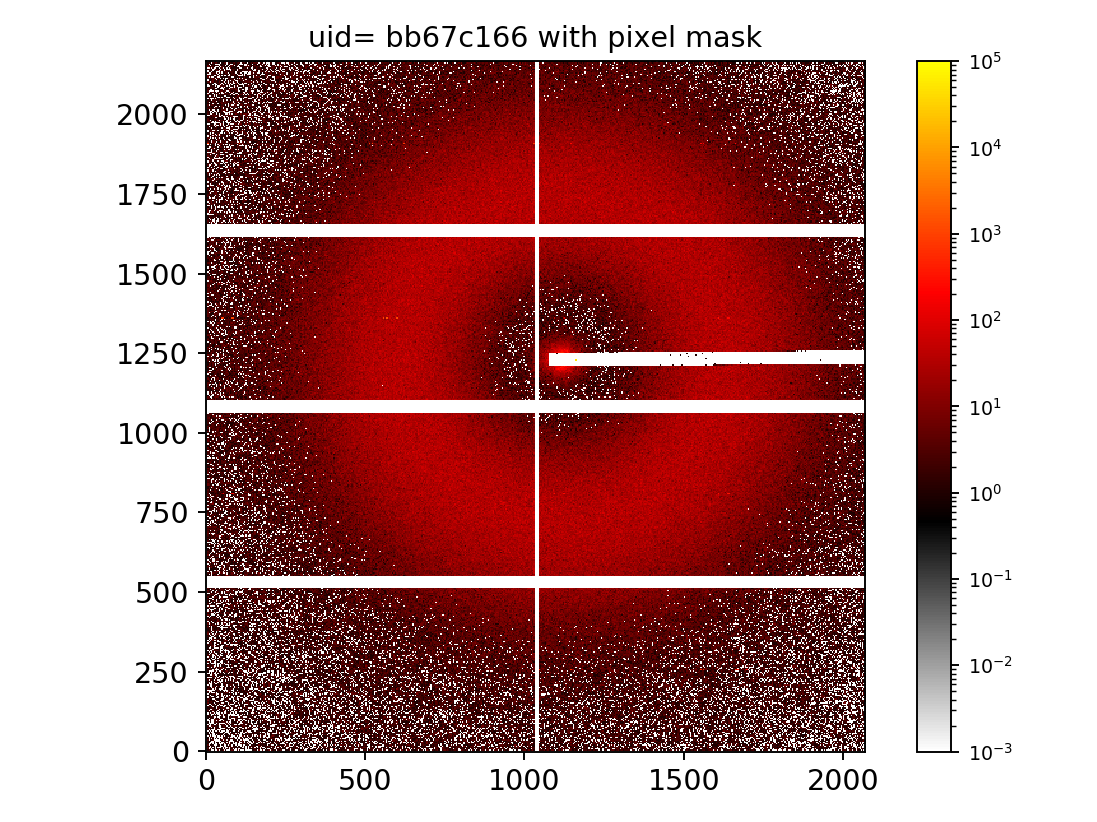

In [23]:
show_img(avg_img*pixel_mask*rmask,vmin=0.1e-2,vmax=1e5, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

### To create multi-rectangle masks, for each sub-mask



In [24]:
#creat the right part mask

if '4m' in md['detector']:
    partial_mask = create_cross_mask(  avg_img, center=[md['beam_center_x']- 60, md['beam_center_y']  ], #center=[509,185],
                            wy_left= 0, wy_right= 40, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )
elif '500K' in md['detector']:
    partial_mask = create_cross_mask(  avg_img, center=[md['beam_center_x'] -3, md['beam_center_y']+45  ], #center=[509,185],
                               wy_left= 0, wy_right= 0, 
                               wx_up= 0, wx_down= 25,center_radius= 0 )
else:
    print('Please check the detectors.')



<IPython.core.display.Javascript object>


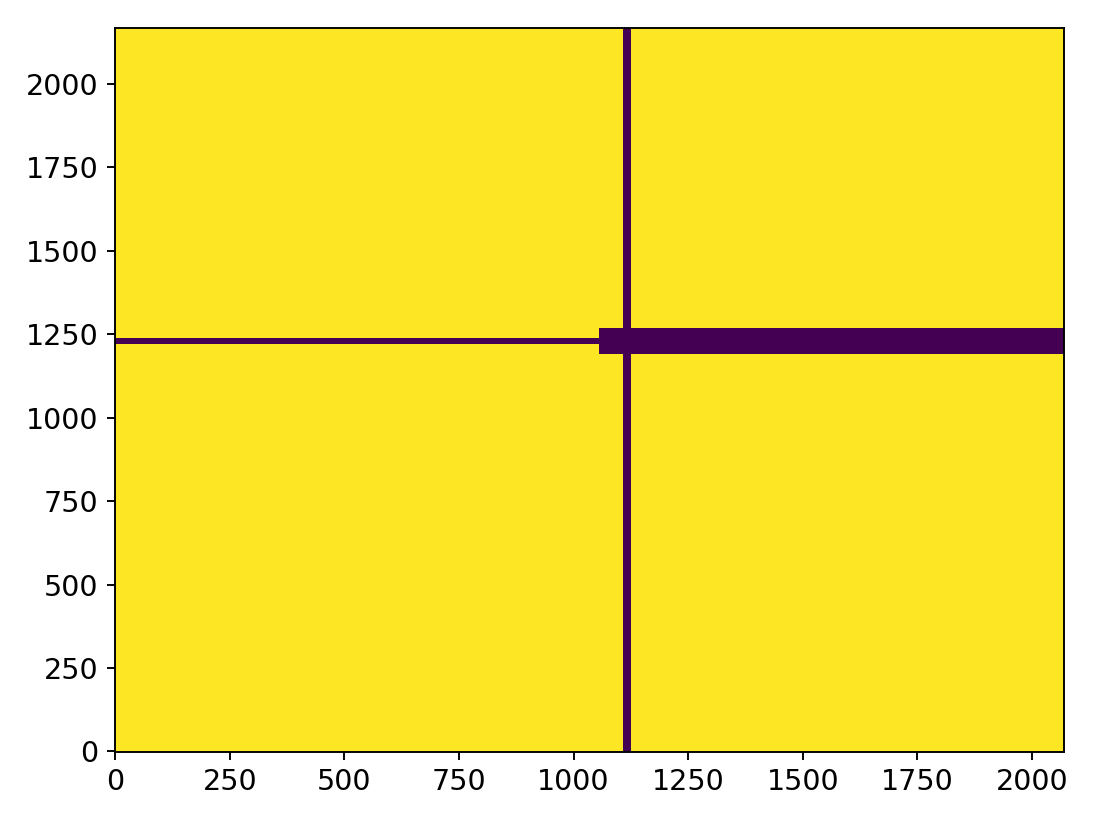

In [25]:
show_img(  partial_mask, show_colorbar=False   )

In [26]:
#np.save( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop', partial_mask )
#Ver_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop.npy' )
#Ver_Beamstop = move_beamstop( Vertical_Beamstop, xshift=0, yshift=0 )

In [27]:
#parasitic scattering from slits
#partial_mask *= create_cross_mask(  avg_img,center=[1300,1469],
#                            wy_left= 0, wy_right= 40, 
#                            wx_up= 0, wx_down= 0,center_radius= 0 )
#parasitic scattering from slits
#partial_mask *= create_cross_mask(  avg_img,center=[946,1700],
#                            wy_left= 0, wy_right= 0, 
#                            wx_up= 0, wx_down= 0,center_radius= 0 )
#parasitic scattering from slits
#partial_mask *= create_cross_mask(  avg_img,center=[ 946,2167-60],
#                            wy_left= 0, wy_right= 0, 
#                            wx_up= 0, wx_down= 0,center_radius= 0 )


In [28]:
#Some bad lines between chips - should be masked elswhere
#partial_mask[1909:1910,:] = False
#partial_mask[257:259,:] = False

<IPython.core.display.Javascript object>


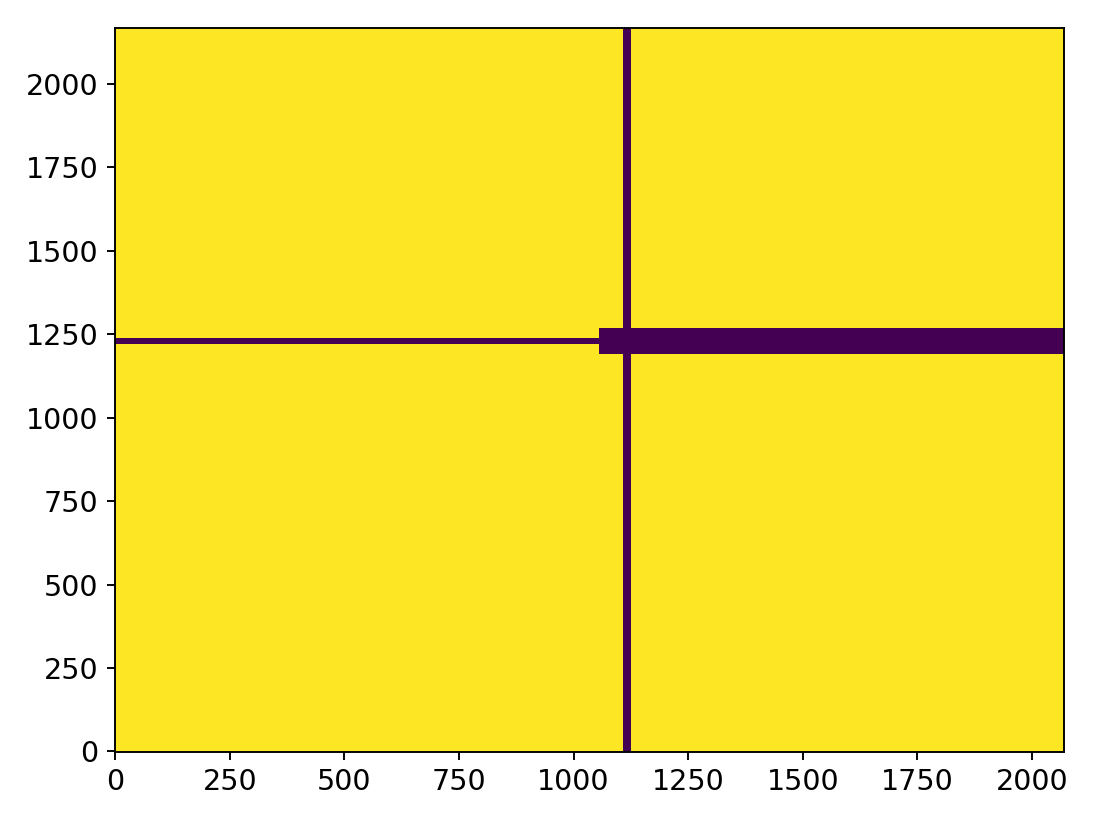

In [29]:
show_img(  partial_mask, show_colorbar=False   )

In [30]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ md['beam_center_x'], md['beam_center_y'] ],
                            wy_left= 10, wy_right= 10, 
                              wx_up= 10, wx_down=10,center_radius=0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [31]:
#creat the left/right/up/down part mask
#partial_mask *=  create_cross_mask(  avg_img, center=[ 1600,1800+25 ],
#                            wy_left= 0, wy_right= 0, 
#                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [32]:
#from chxanalys.chx_generic_functions import create_multi_rotated_rectangle_mask

In [33]:
#np.save( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop', partial_mask )
#Hor_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop.npy' )
#Hor_Beamstop = move_beamstop( Hor_Beamstop, xshift=0, yshift=0 )

<IPython.core.display.Javascript object>


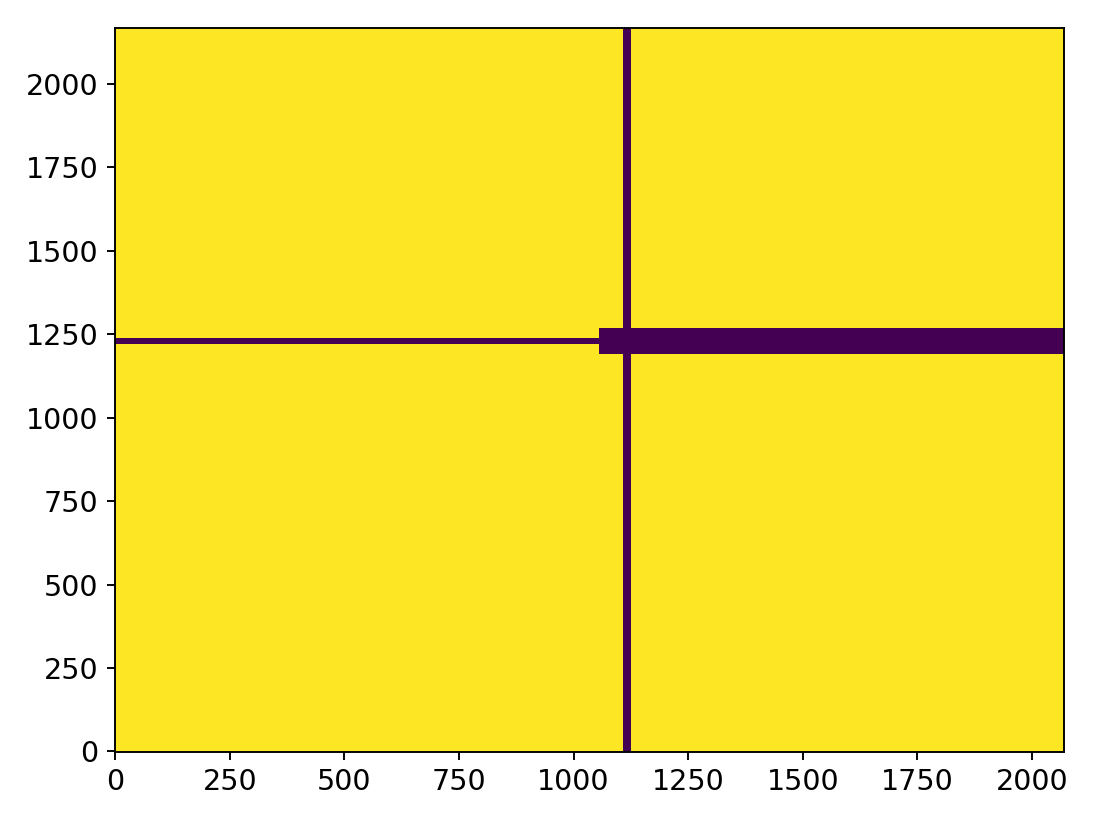

In [34]:
show_img(  partial_mask , show_colorbar=False   )

In [35]:
#creat the left/right/up/down part mask
#partial_mask *=  create_cross_mask(  avg_img, center=[ 1030,395],
#                            wy_left= 145, wy_right= 0, 
#                              wx_up= 0, wx_down= 0,center_radius= 0 )


In [36]:
#np.save( '/XF11ID/analysis/2017_1/masks/Bad_4M', partial_mask )
#Bad_4M = np.load( '/XF11ID/analysis/2017_1/masks/Bad_4M.npy' )
 

In [37]:
#create a circle mask for windows
if False: #make it True to make window mask
    window_shadow  = ~create_cross_mask(  avg_img, center=[ 911,997],
                           wy_left= 0, wy_right= 0, 
                             wx_up= 0, wx_down= 0,center_circle=True, center_radius= 680)
else:
    window_shadow = 1

In [38]:
full_mask = partial_mask *window_shadow
#full_mask = Ver_Beamstop * Hor_Beamstop *Bad_4M *window_shadow

In [39]:
#show_img( full_mask, aspect = 1 )

In [40]:
mask = np.array ( full_mask * pixel_mask*mask_rh * rmask , dtype = bool )
#mask = np.array ( full_mask * pixel_mask , dtype = bool )

<IPython.core.display.Javascript object>


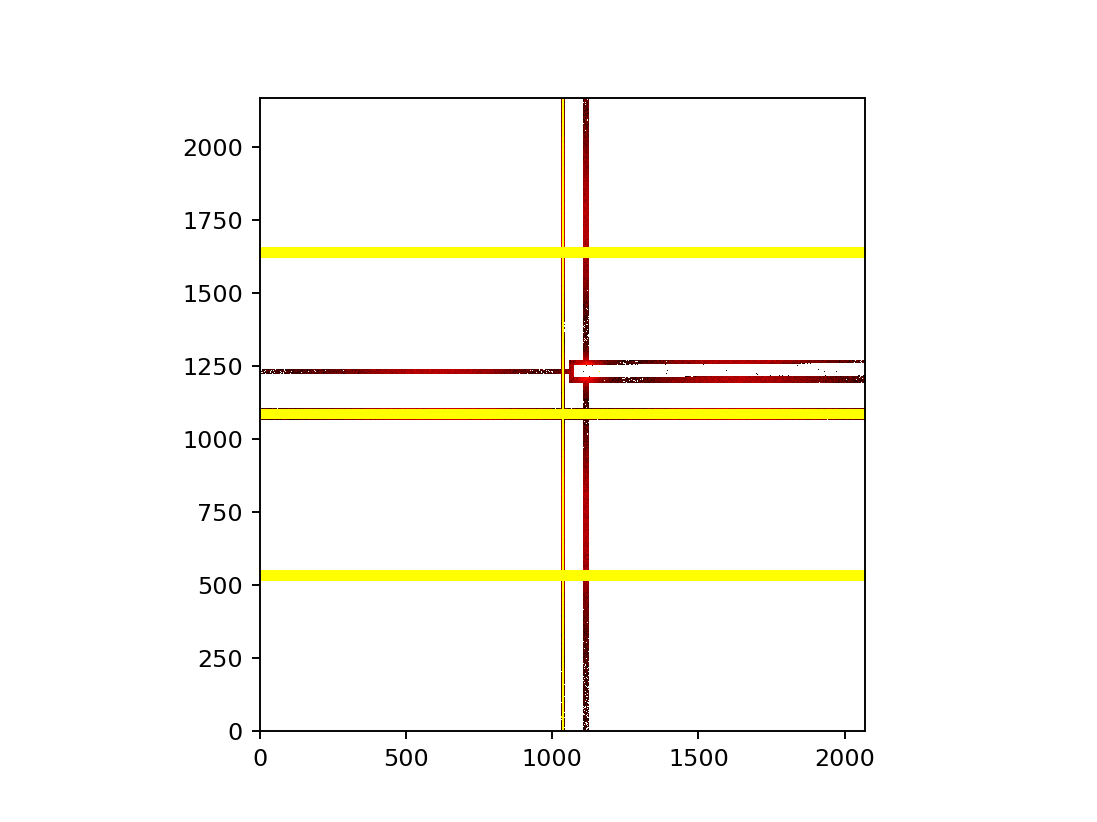

In [41]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax= 1e5), cmap= cmap_albula)
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


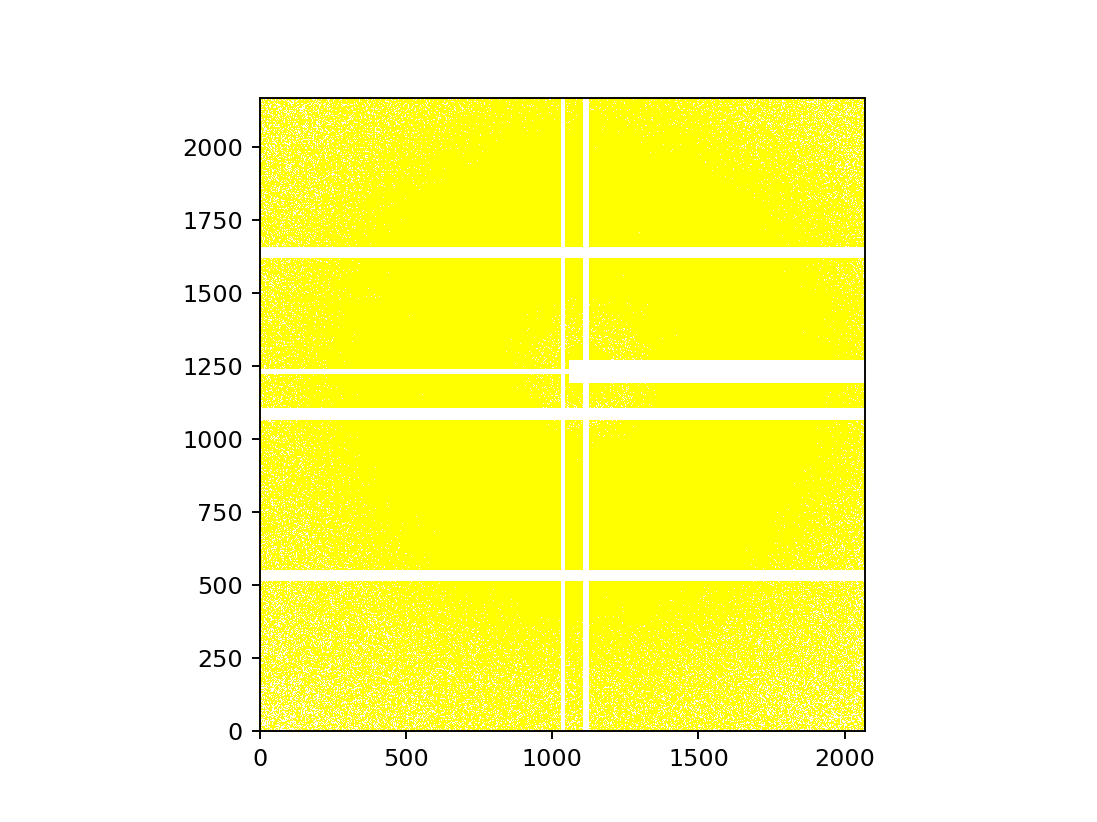

In [42]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap= cmap_albula,origin='lower',
               norm= LogNorm( vmin=.1e-3, vmax=1e0 ),
               interpolation='none')
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


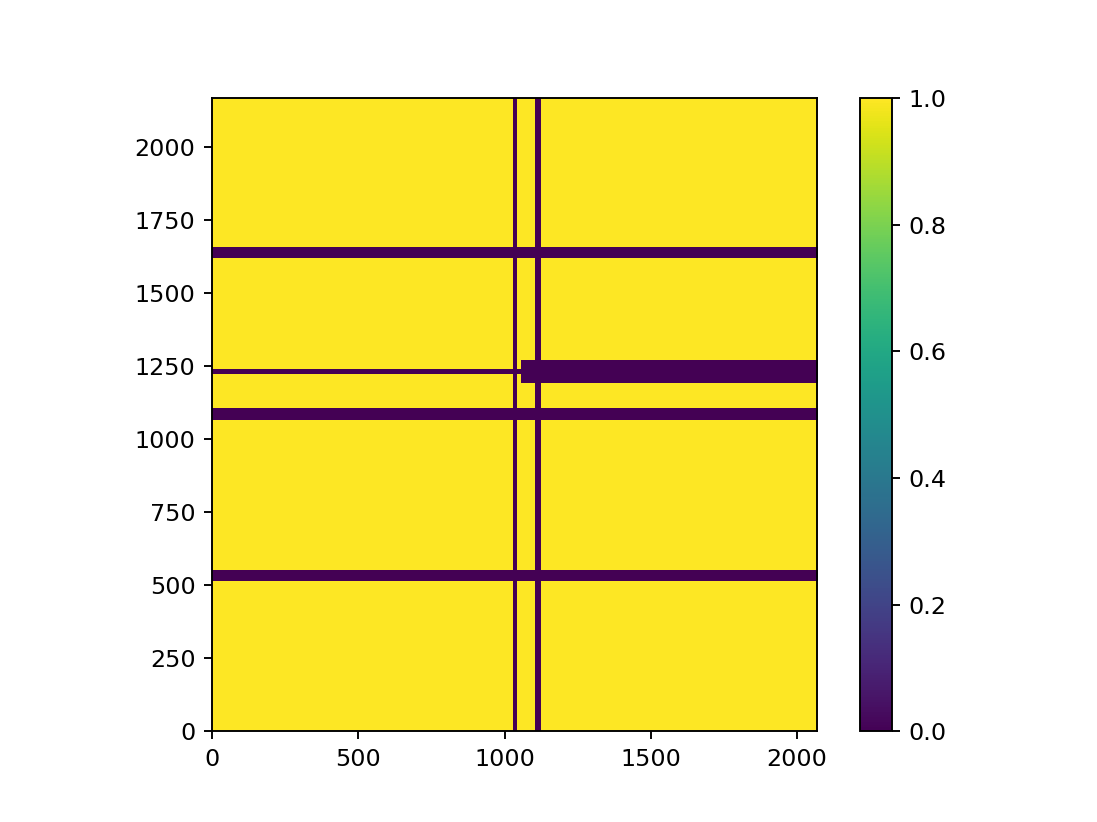

In [43]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [44]:
np.save(  path +   uid +"_mask", mask)

In [45]:
path +   uid +"_mask"

'/XF11ID/analysis/2019_3/masks/bb67c166_mask'

#### save with a meaningful filename, make False after excute to avoid overwrite

In [46]:
#if True:
if False:    
    date='June26'
    if '4m' in md['detector']:
        meaningful_name = '%s_2019_4M_SAXS'%date#_centered'
    elif '500K' in md['detector']:
        meaningful_name = '%s_2019_500K_SAXS'%date#_centered'
    np.save(  path +   meaningful_name, mask)
    print( path +   meaningful_name )

In [47]:
#path +   meaningful_name

In [48]:
uid

'bb67c166'